In [291]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*algorithm did not converge.*")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

PHASE1_DIR = Path(".")
PROCESSED_DIR = PHASE1_DIR / "processed"

In [292]:
evaluations_df = pd.read_parquet(PROCESSED_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,log_cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,1.558145,0.95,1.0,0.0,0.0,0.2,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,-3.506558,0.15,0.0,1.0,1.0,0.4,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,1.316408,0.20,0.0,1.0,2.0,0.9,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.425268,0.60,1.0,1.0,2.0,0.7,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,4.436160,0.90,1.0,1.0,3.0,0.3,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,5.339123,0.45,0.0,0.0,0.0,0.2,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,5.703816,0.20,1.0,0.0,3.0,0.6,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,1.169381,0.95,1.0,1.0,3.0,0.9,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,2.847232,0.65,0.0,0.0,1.0,0.5,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


In [421]:
from utils import get_n_splits

In [422]:
train_idx, test_idx = next(get_n_splits(df, n=2, instance_number=10, solver_number=300, random_state=0))

rng = np.random.default_rng(0)
df_train = df.loc[train_idx]

solver_avg_costs = df_train.groupby("solver_id")["cost"].mean().reset_index()
cost = solver_avg_costs["cost"].to_numpy()
probs = cost / np.sum(cost)

unique_solvers = solver_avg_costs["solver_id"].to_numpy()
num_solvers = len(unique_solvers)
solver_permutation = np.zeros(num_solvers, dtype=object)
remaining_indices = np.arange(num_solvers)
for i in range(num_solvers):
    curr_probs = probs[remaining_indices] / np.sum(probs[remaining_indices])
    chosen_idx = rng.choice(len(remaining_indices), p=curr_probs)
    solver_idx = remaining_indices[chosen_idx]
    solver_permutation[i] = unique_solvers[solver_idx]
    remaining_indices = np.delete(remaining_indices, chosen_idx)

solver_order = {solver_id: order for order, solver_id in enumerate(solver_permutation)}
df_train["solver_order"] = df_train["solver_id"].map(solver_order)
df_train = df_train.sort_values(["solver_order", "instance_id"])
cum_min_cost = df_train.groupby("instance_id")["cost"].cummin()
df_train = df_train.drop(columns=["solver_order"])

#
cut_off = np.clip(cum_min_cost + rng.lognormal(0, 1, size=cum_min_cost.shape[0]), 0.01, 300)
X_train = df_train.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
y_train = np.zeros(X_train.shape[0], dtype=[('is_censored', bool), ('cost', float)])
y_train['is_censored'] = (df_train["cost"] >= cut_off).to_numpy()
y_train['cost'] = df_train["cost"].clip(upper=cut_off)

df_test = df.loc[test_idx]
X_test = df_test.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
y_test = df_test["cost"].to_numpy()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [423]:
from sksurv.ensemble import RandomSurvivalForest

model = RandomSurvivalForest(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=15,
    n_jobs=-1,
    random_state=0,
)
model.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_jobs=-1,
                     random_state=0)

In [424]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

model2 = CoxPHSurvivalAnalysis(alpha=1.0, ties='efron')
model2.fit(X_train, y_train)

CoxPHSurvivalAnalysis(alpha=1.0, ties='efron')

In [425]:
y_pred = pd.Series(model.predict(X_test))
y_pred2 = pd.Series(model2.predict(X_test))

In [426]:
sf_pred = model.predict_survival_function(X_test, return_array=True)
sf_pred2 = model2.predict_survival_function(X_test, return_array=True)

In [427]:
def survival_to_pmf(sf_pred):
    sf_pred = np.append(sf_pred, np.zeros(shape=(sf_pred.shape[0], 1)), axis=1)
    pmf = -np.diff(sf_pred)  # P(t_i) = S(t_i) - S(t_{i+1})
    return pmf

def expected_time(times, pmf):
    return np.sum(times * pmf)

pmf = survival_to_pmf(sf_pred2)
y_pred = np.sum(pmf * model.unique_times_, axis=1)
# cdf = np.cumsum(pmf, axis=1)
# y_pred = np.array([model.unique_times_[np.searchsorted(x, 0.5)] for x in cdf])

# y_pred = np.array([rng.choice(model.unique_times_, p=p) for p in pmf])

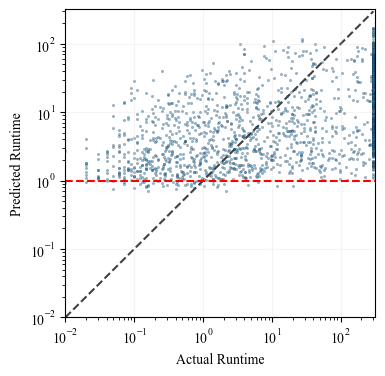

In [428]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sc = ax.scatter(
    y_test,
    y_pred,
    alpha=0.5,
    edgecolors="k",
    lw=0.2,
    s=3,
)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(0.01, 320)
ax.set_ylim(0.01, 320)
ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
ax.axhline(y=1, color='red', linestyle='--')

ax.set_ylabel("Predicted Runtime")
ax.set_xlabel("Actual Runtime")
# plt.savefig("xgboost_aft.png", dpi=300, bbox_inches="tight")
plt.show()